## 5-1. 결정 트리 
#### 학습 목표 
- 결정 트리 알고리즘을 사용해 새로운 분류 문제를 다루어 보고, 머신러닝 문제를 어떻게 해결하는지 이해하고자 한다. 

## 1. 로지스틱 회귀로 와인 분류하기 
- 책의 예제를 보면 한빛 마켓에서 품질이 좋은 와인을 캔으로 판매하는 작업을 진행한다. 그런데 입고된 와인을 보니 급하게 제작하는 바람에 레드 와인과 화이트 와인의 표시가 누락 되었다. 캔에 인쇄된 **'알코올 도수', '당도', 'PH 값'**으로 와인의 종류를 구분해달라는 요청을 하였다.
- 우선 품질관리 팀에서 6,497개의 와인 샘플 데이터를 보내주었다. 해당 데이터를 이용하여 로지스틱 회귀 모델을 적용해보고자 한다. (데이터 발췌: [kaggle 'Red Wine Quality' 데이터 셋](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009))

In [1]:
# 데이터 불러오기 
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

alcohol  sugar    pH  class
0      9.4    1.9  3.51    0.0
1      9.8    2.6  3.20    0.0
2      9.8    2.3  3.26    0.0
3      9.8    1.9  3.16    0.0
4      9.4    1.9  3.51    0.0

- 처음 3개의 열 **(alcohol, sugar, pH)**은 각각 **알코올 도수, 당도, pH값**을 나타낸다.
- 네 번째 열 **(class)**은 타깃값으로 **0이면 레드 와인**, **1이면 화이트 와인**을 나타낸다.
- 레드 와인과 화이트 와인을 구분하는 **이진 분류**문제이고, **화이트 와인이 양성 클래스** 이다. 즉 전체 와인 데이터에서 화이트 와인을 골라내는 문제라고 볼 수 있다.
- 그럼 로지스틱 회귀 모델로 훈련하기전 pandas에서 유용한 메서드 2개를 살표보고자 한다. 
- 먼저 볼 메서드는 **'info()'** 메서드로 데이터브레임의 각 열의 데이터 타입과 누락된 데이터가 있는지 확인해준다. 

In [2]:
# info()메서드로 데이터 타입 확인하기 
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


- 출력 결과 **총 6,497개의 샘플**이 있고, 4개 데이터 타입 모두 **'float(실수)'**, 'Non-null Count'가 모두 6,497 이므로 **결측값도 없다**.
- 참고로 만약 결측치가 존재한다면, 그 데이터를 버리거나 평균값으로 채운 후 사용할 수 있다. 어떤 방식이 최선인지 미리 알기 어려우므로, 두 가지 모두 시도해봐야한다. 여기에서도 항상 훈련 세트의 통계 값으로 테스트 세트를 변환한다는 것, 즉 훈련 세트의 평균값으로 테스트 세트의 누락된 값을 채워야 함을 잊지말아야 한다.
- 다음에 알아보 메서드는 바로 **'describe()'** 이다. 이 메서드는 열에 대한 간략한 통계('최소', '최대', '평균값' 등)를 출력해준다.

In [3]:
# describe() 메서드로 데이터의 간략한 통계 확인하기 
wine.describe()

alcohol        sugar           pH        class
count  6497.000000  6497.000000  6497.000000  6497.000000
mean     10.491801     5.443235     3.218501     0.753886
std       1.192712     4.757804     0.160787     0.430779
min       8.000000     0.600000     2.720000     0.000000
25%       9.500000     1.800000     3.110000     1.000000
50%      10.300000     3.000000     3.210000     1.000000
75%      11.300000     8.100000     3.320000     1.000000
max      14.900000    65.800000     4.010000     1.000000

- **갯수(count), 평균(mean), 표준편차(std), min(최소값), 25%(1사분위수), 50%(중앙값), 75%(3사분위수), max(최대값)**을 볼 수 있다.
- 여기서 알 수 있는 사항은 알코올 도수, 당도, pH값의 스케일이 모두 다르다는 것이다. 
- 이럴 경우 **'StandardScaler' 클래스**를 사용해 feature를 표준화 시킨다.

In [4]:
# feature 표준화 전 - 1. dataframe을 numpy 배열로 바꾸기 
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [5]:
# 데이터 확인 - data 데이터 
data

array([[ 9.4 ,  1.9 ,  3.51],
       [ 9.8 ,  2.6 ,  3.2 ],
       [ 9.8 ,  2.3 ,  3.26],
       ...,
       [ 9.4 ,  1.2 ,  2.99],
       [12.8 ,  1.1 ,  3.34],
       [11.8 ,  0.8 ,  3.26]])

In [6]:
# 데이터 확인 - target 데이터 
target

array([0., 0., 0., ..., 1., 1., 1.])

In [7]:
# feature 표준화 전 - 2. 훈련, 테스트 세트로 나누기 
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

- train_test_split() 함수는 설정값을 지정하지 않으면 25%를 테스트 세트로 지정한다. 샘플 개수가 충분히 많으므로, 20% 정도만 테스트 세트로 나누었다. (test_size=0.2)

In [8]:
# 훈련 세트, 테스트 세트 크기 확인 
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


- 훈련 세트는 5,197개, 테스트 세트는 1,300개로 나누어졌다.

In [9]:
# Feature 표준화 작업 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [10]:
# 훈련 세트 전처리 작업 내역 확인
train_scaled

array([[ 0.01376574,  0.4646116 , -0.16888369],
       [ 1.60871671, -0.70299854,  0.26967864],
       [ 1.10504798, -0.70299854,  1.20945505],
       ...,
       [-0.82568214,  0.0267578 ,  0.14437512],
       [-0.82568214,  0.52716215, -0.23153545],
       [-0.82568214, -0.57789745,  1.83597265]])

In [11]:
# 테스트 세트 전처리 작업 내역 확인 
test_scaled

array([[ 1.44082714,  1.52797084,  0.26967864],
       [-0.48990299, -0.68214836,  0.3323304 ],
       [ 1.27293756,  0.40206106, -0.23153545],
       ...,
       [ 1.60871671, -0.76554908, -0.16888369],
       [-0.90962693,  0.88161523,  0.52028568],
       [-1.49724045,  2.09092573, -1.98578474]])

In [12]:
# 로지스틱 회귀 모델 훈련하기 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)

# 훈련 평가하기 
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


- 로지스틱 회귀 모델로 훈련하고 평가한 결과 0.78, 0.77로 점수가 높지 않다. 
- 그리고 훈련 세트와 테스트세트의 점수가 모두 낮으니 모델이 다소 과소적합 된 것으로 보인다. 
- 해당 문제를 해결하기 위해서, 규제 매개 변수 C의 값을 바꾸거나, solver 매개변수에서 다른 알고리즘을 선택하는 방법이 있다.

### 1-1. 설명하기 쉬운 모델과 어려운 모델 
- 이 결과를 보고하기 위해 보고서를 만들고자 하는데, 이 모델을 설명하기 위해 로지스틱 회귀가 학습한 계수와 절편을 출력해보자

In [13]:
# 계수와 절편 출력 
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


- 이제 보고서를 작성해보자
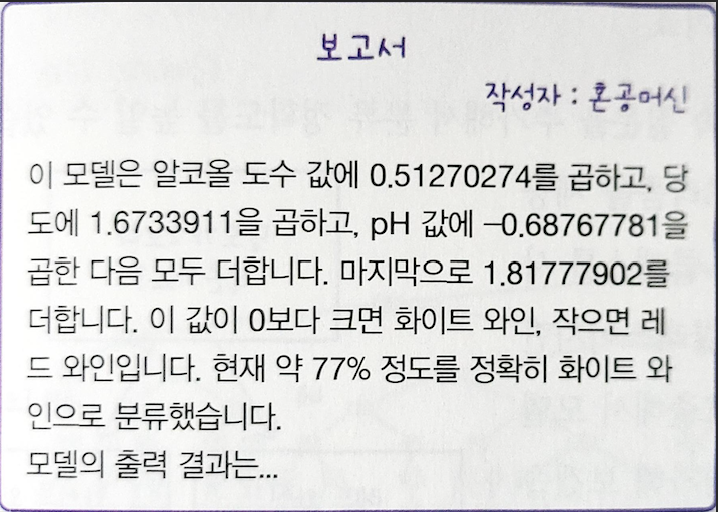

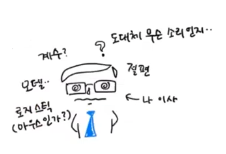

- 과연 로지스틱 회귀 모델을 잘 이해할 수 있을까? 사실 우리는 이 모델이 왜 저런 계수 값을 학습했는지 정확히 이해하기 어렵다. 왜냐면 그저 추측일 뿐이다. 
- 아마 알코올 도수와 당도가 높을수록 화이트 와인일 가능성이 높고, pH값(농도)가 높을 수록 레드 와인일 가능성이 높을 것 같다. 하지만 정확히 이 숫자가 어떤 의미인지는 설명하기 어렵다. (대부분 머신러닝의 결과들이 이렇게 설명하기 어렵게 되어 있다.)
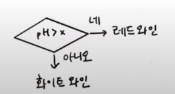
- 위의 그림처럼 좀 더 쉬운 방법은 없는 것 일까?

## 2. 결정 트리

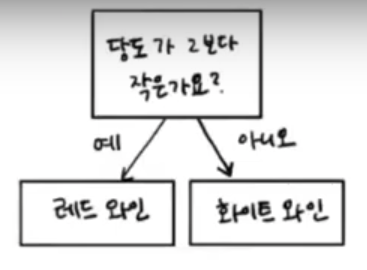

- 대표적으로 많이 보는 것이 <font color=red>**'결정 트리(Decision Tree)'**</font> 모델이다. 결정 트리 모델은 스무고개와 같다. 위 그림과 같이 질문을 하나 던져놓고 정답과 맞춰가는 것을 말한다.
- 데이터를 잘 나눌 수 있다는 질문을 찾는다면 계속 질문을 추가해서 분류 정확도를 높일 수 있다.
- 결정 트리는 사이킷런에서 제공하는 <font color=red>**'DecisionTreeClassifier 클래스'**</font>를 사용해 결정 트리 모델을 훈련한다. (이전과 동일하게 **'fit() -> score() 형식'**)

In [15]:
# 결정 트리 모델 훈련 및 평가 
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# 모델 훈련 
dt.fit(train_scaled, train_target)

# 모델 평가
print(dt.score(train_scaled, train_target)) # 훈련 세트
print(dt.score(test_scaled, test_target))   # 테스트 세트

0.996921300750433
0.8592307692307692


- 결정 트리로 훈련, 테스트 세트를 훈련하고 평가한 결과 훈련 세트 0.99, 테스트 세트 0.85로 점수 자체는 높아 졌지만, 테스트 세트가 훈련 세트에 비해 낮아, 과대 적합된 모델이라고 보여진다.

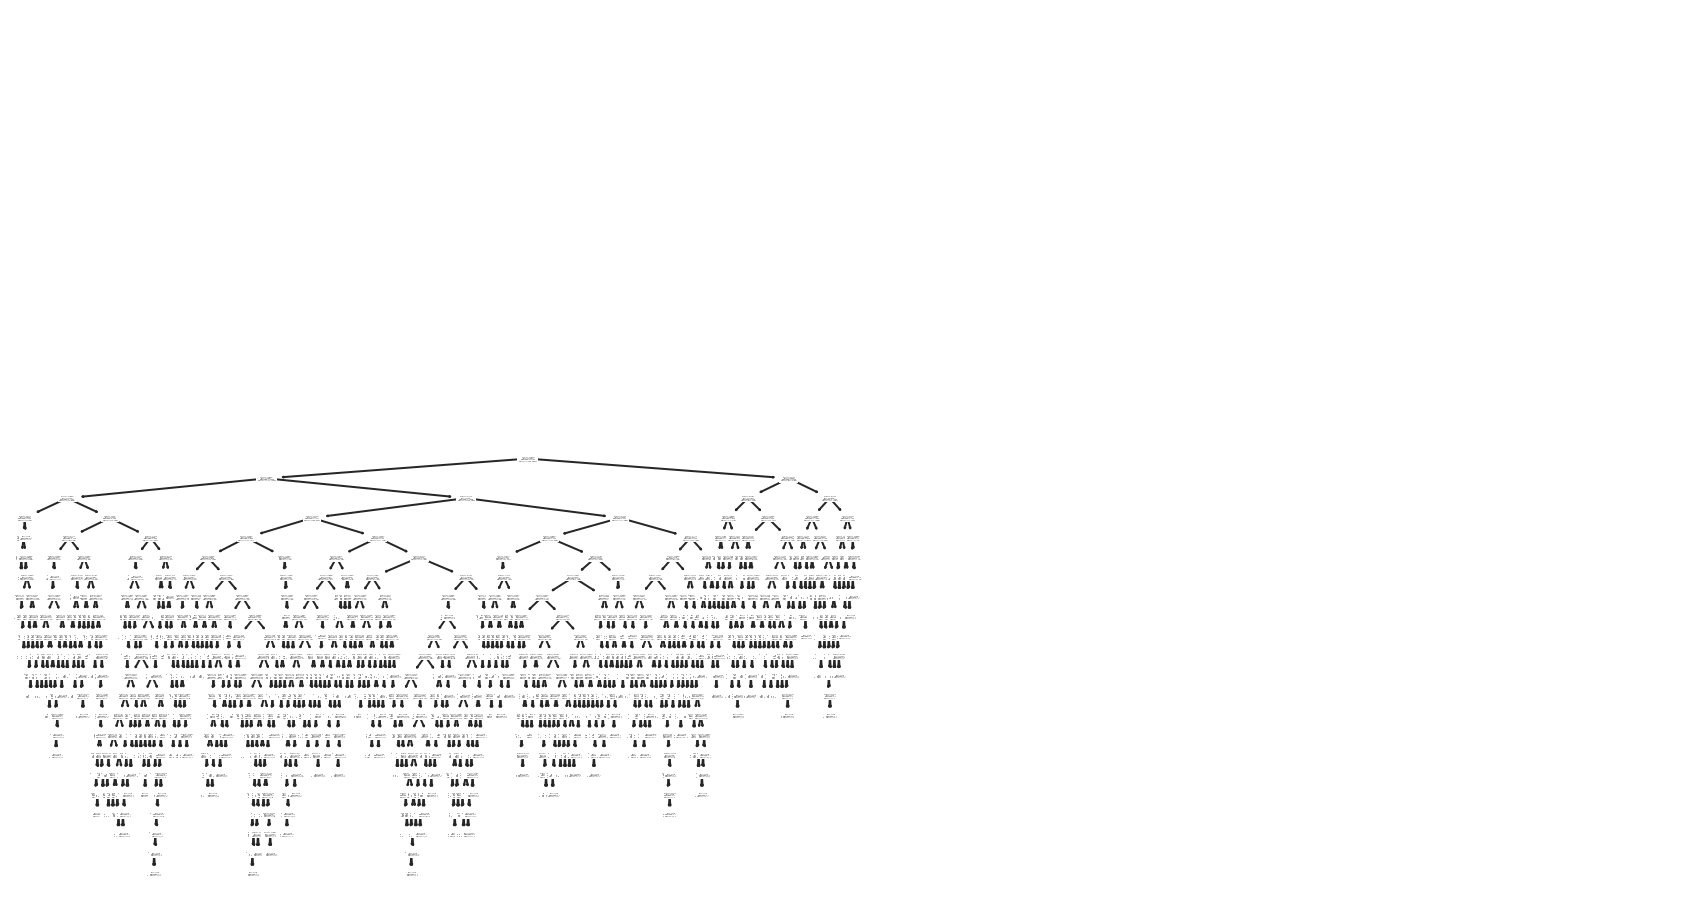

In [18]:
# 결정 트리 시각화 - 위에서 만든 결정 트리 모델 객체를 plot_tree() 함수에 전달하여 트리 시각화
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(dt)
plt.show()

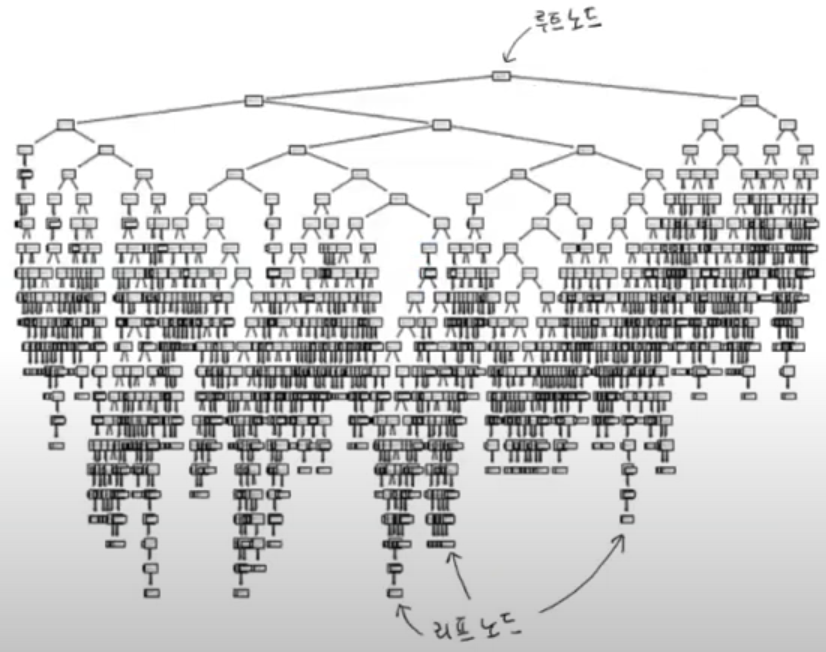

- 확대하여 살펴보니 복잡하게 보이지만 수양버들 나뭇잎처럼 늘어진 트리가 만들어졌다.
- 진짜 수양버들 나무는 밑에서 부터 하늘위로 자라나지만, 결정 트리는 위에서부터 아래로 거꾸로 자란다. 
- 맨 위의 노드(node)를 <font color=blue>루트 노드(root node)</font>라 부르고 맨 아래 끝에 달린 노드를 <font color=blue>리프 노드(leaf node)</font> 라고 한다.
- 참고로 **노드(node)**는 결정 트리를 구성하느 핵심 요소이다. 노드는 훈련 데이터의 특성에 대한 테스트를 표현한다. 예를 들어 현재 샘플의 당도가 -0.239보다 작거나 같은지 테스트 한다. 가지(branch)는 테스트의 결과(True, False)를 나타내며 일반적으로 하나의 노드는 2개의 가지를 가진다.

- 위의 트리를 살펴보니 너무 복잡해 보인다. plot_tree() 함수에서 트리의 깊이를 제한해서 출력해보자. 
    - max_depth 매개변수를 1로 주면 루트 노드를 제외하고 하나의 노드를 더 확장해서 그린다. 
    - filled 매개변수에서 클래스에 맞게 노드의 색을 칠할 수있다.
    - feature_names 매개변수에서는 특성의 이름을 전달할 수 있다.

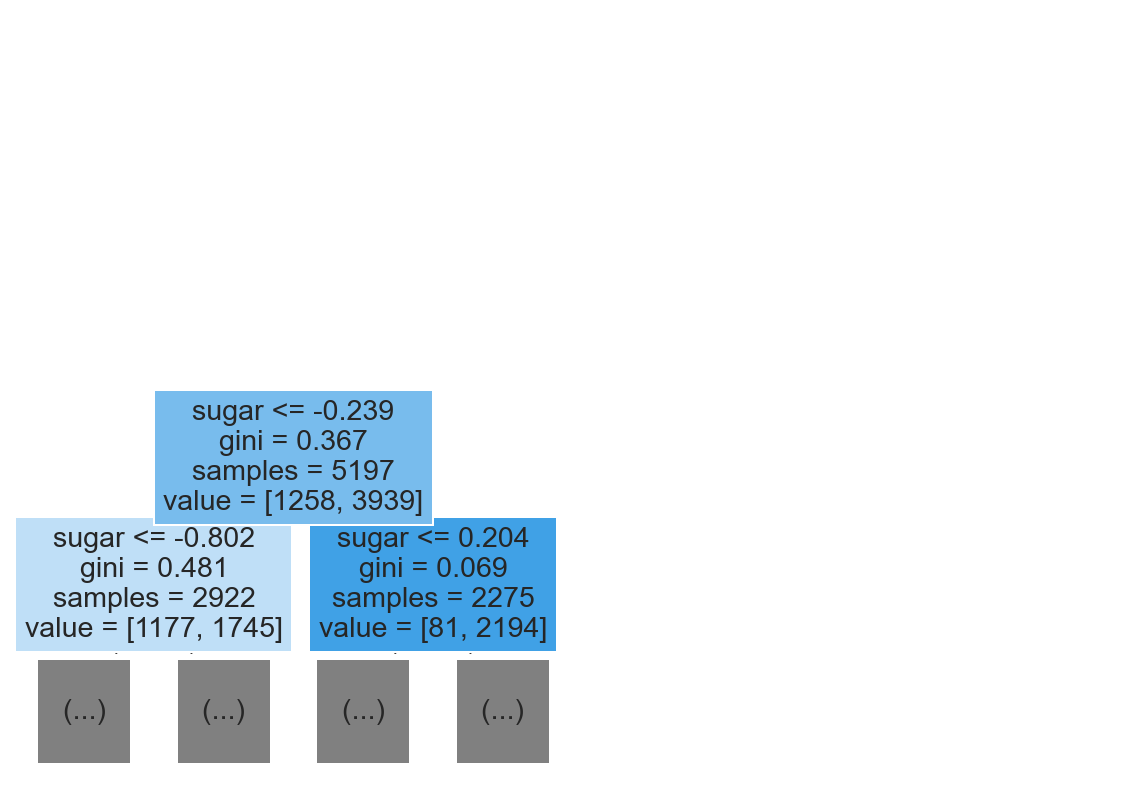

In [19]:
# 트리의 깊이를 제한해서 출력 
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

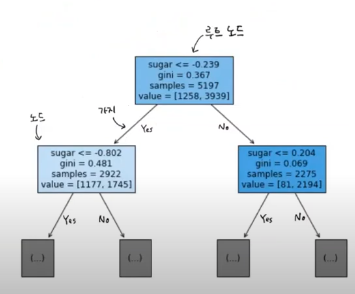

- 트리의 기본 정보는 아래와 같다. 
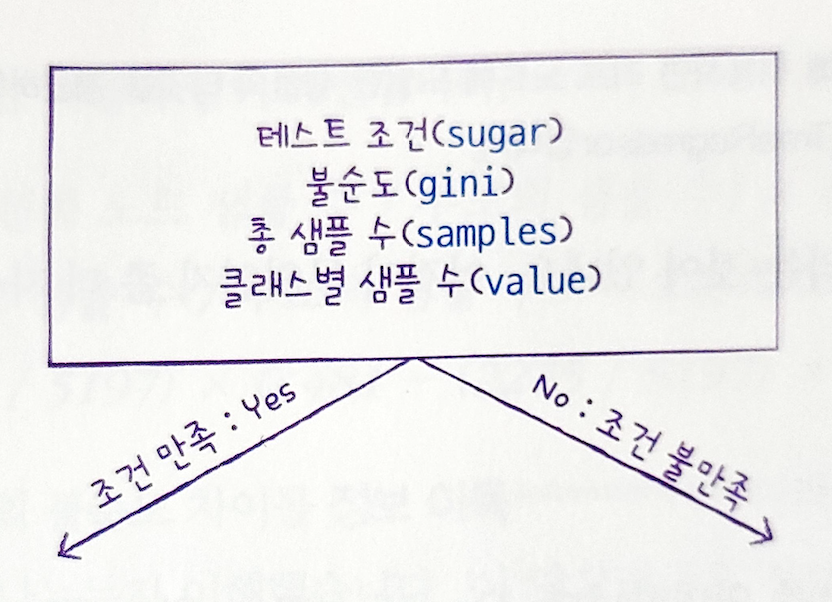

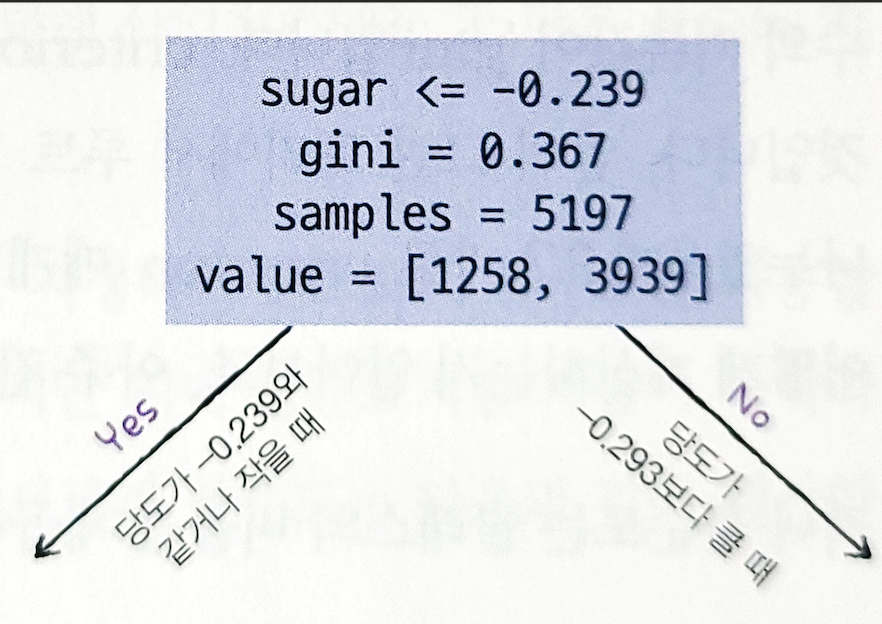

- 하나씩 살펴보면, **루트 노드는 당도(sugar)가 -0.239 이하인지 질문한다.** 만약 어떤 샘플의 당도가 **-0.239와 같거나 작으면 왼쪽 가지(Yes)로, 그렇지 않으면 오른쪽 가지(No)로 이동 한다.** 
- 루트 노드의 총 샘플 수(samples)는 **5,197개** 이다. 
- 이 중 음성 클래스(레드 와인)는 **1,258개**, 양성 클래스(화이트 와인)는 **3,939개** 이다. (해당 값들은 value에 나타나있다.)

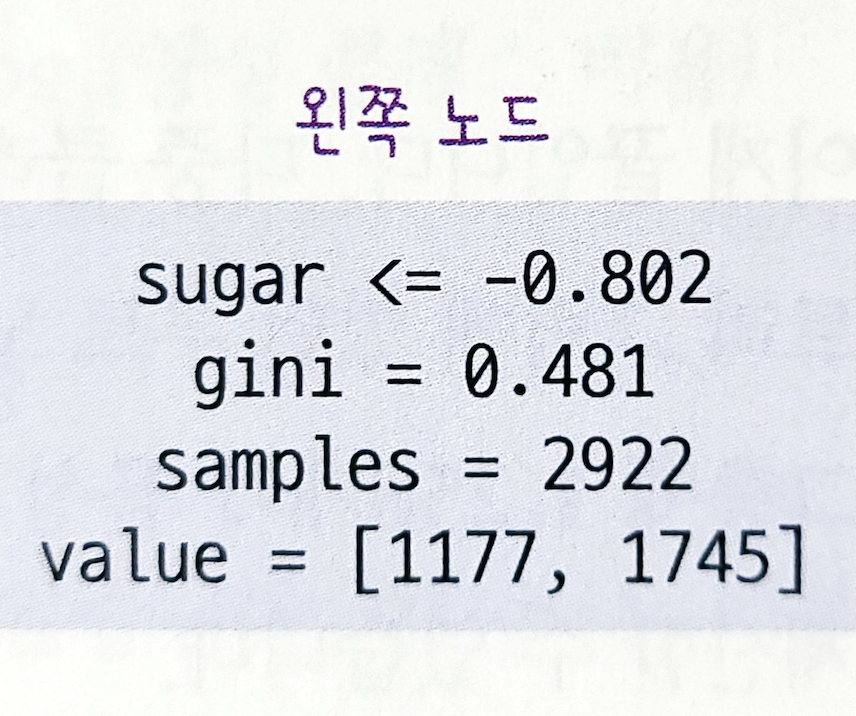

- 왼쪽 노드를 살펴보면, **당도가 더 낮은지 질문한다.** 당도가 **-0.802**와 같거나 낮다면 다시 왼쪽 가지로, 그렇지 않으면 오른쪽 가지로 이동 한다.
- 이 노드에서 음성 클래스와 양성 클래스 샘플 개수는 각각 **1,177개와 1,745개** 이다.
- 루트 노드 보다 양성 클래스 즉 **화이트 와인의 비율이 크게 줄었다.**

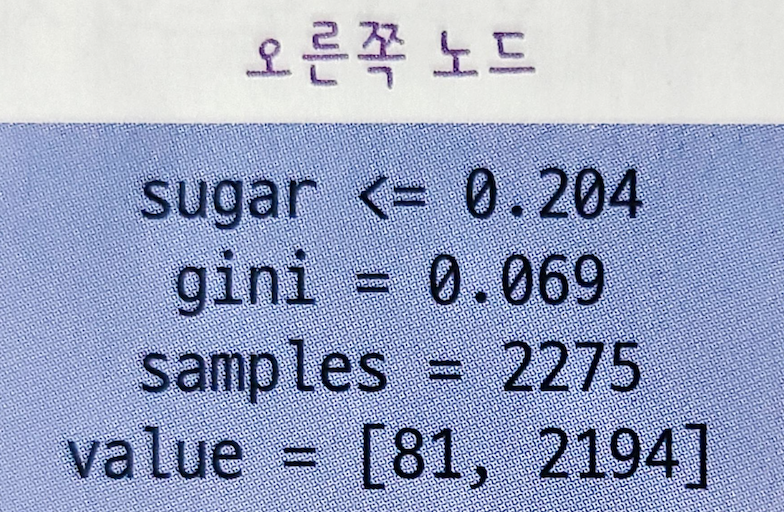

- 루트 노드 보다 화이트 와인의 비율이 크게 줄어든 이유는 오른쪽 노드를 살펴보면 알 수 있다. 해당 노드는 음성 클래스가 81개, 양성 클래스가 2,194개로 대부분 화이트 와인 샘플이 이 노드로 이동했다.
- 노드의 바탕 색깔을 유심히 보면, 루트 노드보다 오른쪽 노드가 더 진하고, 왼쪽 노드는 더 연해졌다. (plot_tree() 함수에서 filled=True로 지정하면 클래스 마다 색깔을 부여하여, 어떤 클래스의 비율이 높아지면 점점 진한 색으로 표시하게 만든다.)

- 결정 트리에서 예측하는 방법은 간단하다. 리프 노드에서 가장 많은 클래스가 예측 클래스가 된다. 앞에서 보았단 K-최근접 이웃과 매우 흡사하다. 
- 만약 이 결정 트리의 성장을 여기서 멈춘다면 왼쪽 노드에 도달한 샘플과 오른쪽 노드에 도달한 샘플 모두 양성 클래스로 예측된다. (두 노드 모두 양성 클래스의 개수가 많기 때문이다.)

### 2-1. 불순도 (gini)
- 노드 안에 있는 gini는 어떤 의미일까? 바로 <font color=blue>**지니 불순도**</font>를 의미한다.
- DecisionTreeClassifier 클래스의 criterion 매개변수의 기본값이 'gini'이다. criterion 매개변수의 용도는 노드에서 데이터를 분할할 기준을 정하는 것이다.
- 앞의 트리에서 루트 노드는 어떻게 당도 -0.239를 기준으로 왼쪽과 오른쪽 노드로 나누었을까? 바로 criterion 매개변수에 지정한 지니 불순도를 사용해서이다.

- 지니 불순도는 클래스의 비율을 제곱해서 더한 다음 1에서 빼면 된다. 공식은 다음과 같다
    - $지니 불순도 = 1 - (음성 클래스 비율^2 + 양성 클래스 비율^2)$
- 매우 간단하다. 다중 클래스 문제라면 클래스가 더 많겠지만, 계산하는 방법은 동일하다.

- 이제 트리에 있던 루트 노드의 지니 불순도를 계산해보자, 루트 노드는 총 5,197개의 샘플이 있고 그중에 1,258개가 음성 클래스, 3,939개가 양성 클래스 이다. 따라서 다음과 같이 지니 불순도를 계산한다.
    - $1 - ((1258/5197)^2 + (3939/5197)^2) = 0.367$

- 왼쪽과 오른쪽 노드의 지니 불순도도 위와 동일한 방식으로 계산한다.
- 만약 100개의 샘플이 있는 어떤 노드의 두 클래스의 배율이 정확히 1/2씩이라면 지니 불순도는 0.5가 되어 최악이 된다.
    - $1 - ((50/100)^2 + (50/100)^2) = 0.5$

- 만약 노드에 하나의 클래스만 있다면 지니 불순도는 0이 되어 가장 작다. 이런 노드를 순수노드 라고 부른다.
    - $1 - ((0/100)^2 + (0/100)^2) = 0$

- 결정 트리 모델은 **부모 노드(parent node)**와 **자식 노드(child node)**의 불순도 차이가 가능한 크도록 트리플 성장시킨다. 
- 부모 노드와 자식 노드의 불순도 차이를 계산하는 방법은, 먼저 자식 노드의 불순도를 샘플 개수에 비례하여 모두 더한다. 그런다음 부모 노드의 불순도에서 빼면 된다.
- 왼족 노드로는 2,992개의 샘플이 이동했고, 오른쪽 노드로는 2,275개의 샘플이 이동했다. 그럼 불순도 차이의 계산은 다음과 같다.
    - $부모의 불순도 - (왼쪽 노드 샘플 수/부모의 샘플 수) \times 왼쪽 노드 불순도 - (오른쪽 노드 샘풀 수 / 부모의 샘플 수) \times 오른쪽 노드 불순도$
    - $0.367 - (2922/5197) \times 0.481 - (2275/5197) \times 0.069 = 0.066$
- 이런 부모와 자식 노드 사이의 불순도 차이를 **정보 이득(information gain)**이라고 부른다. 
- 이 알고리즘은 정보 이득이 최대가 되도록 데이터를 나누는데, 이때 지니 불순도를 기준으로 사용한다. 

- 하지만 사이킷런에는 또 다른 불순도 기준이 있다. DecisionTreeClassifier 클래스에서 **'criterion=entropy'**를 지정하여 엔트로피 붕ㄹ순도를 사용할 수 있다. 
- 엔트로피 불순도도 노드의 클래스 비율을 사용하지만 지니 불순도처럼 제곱이 아니라 밑이 2인 로그를 사용하여 곱한다.
    - $-음성 클래스 비율 \times log_2(음성 클래스 비율) - 양성 클래스 비율 \times log_2(양성 클래스 비율)$
    - $-(1258/5197) \times log_2(1258/5197) - (3939/5197) \times log_2(3939/5197) = 0.798$

- 보통 기본 값인 지니 불순도와 엔트로피 불순도가 만든 결과의 차이는 크지 않다. (여기서는 기본 값인 지니 불순도를 계속 사용하겠다.)
- 이제 결정 트리 알고리즘을 살펴 보았다. 불순도 기준을 사용해 정보 이득이 최대가 되도록 노드를 분할 한다. 
- 노드를 순수하게 나눌수록 정보 이득이 커진다. 새로운 샘플에 대해 예측할 때에는 노드의 질문에 따라 트리를 이동한다. 
- 그리고 마지막에 도달한 노드의 클래스 비율을 보고 예측을 만든다.

### 2-2. 가지치기 
- 그런데 앞의 트리는 제한 없이 자라났기 때문에 훈련 세트보다 테스트 세트 점수가 낮았다. 해당 문제를 다뤄보자 
- 열매를 잘 맺기 위해 과수원에서 가지치기를 하는 것처럼 결정 트리도 가지치기를 해야 한다. 그렇지 않으면 무작정 끝까지 자라나는 트리가 만들어 진다. 
- 훈련 세트에는 아주 잘 맞겠지만, 테스트 세트에서 점수는 못 미칠 것으로 보인다. 이를 두고 **'일반화가 잘 안 될 것 같다'** 라고 말한다.

- 그럼 가지치기를 해보자. 결정 트리에서 가지치기를 하는 가장 간단한 방법은 자라날 수 있는 트리와 최대 깊이를 지정하는 것이다.
- DecisionTreeClassifier 클래스의 max_depth 매개 변수를 3으로 지정하여 모델을 만들어 보겠다. (이렇게 하면 루트 노드 아래로 쵀대 3개의 노드끼자민 성장할 수 있다.)

In [22]:
# 가지치기 
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

# 모델 평가 
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


- 훈련 세트의 성능은 낮아졌지만, 테스트 세트의 성능은 거의 그대로 이다. 

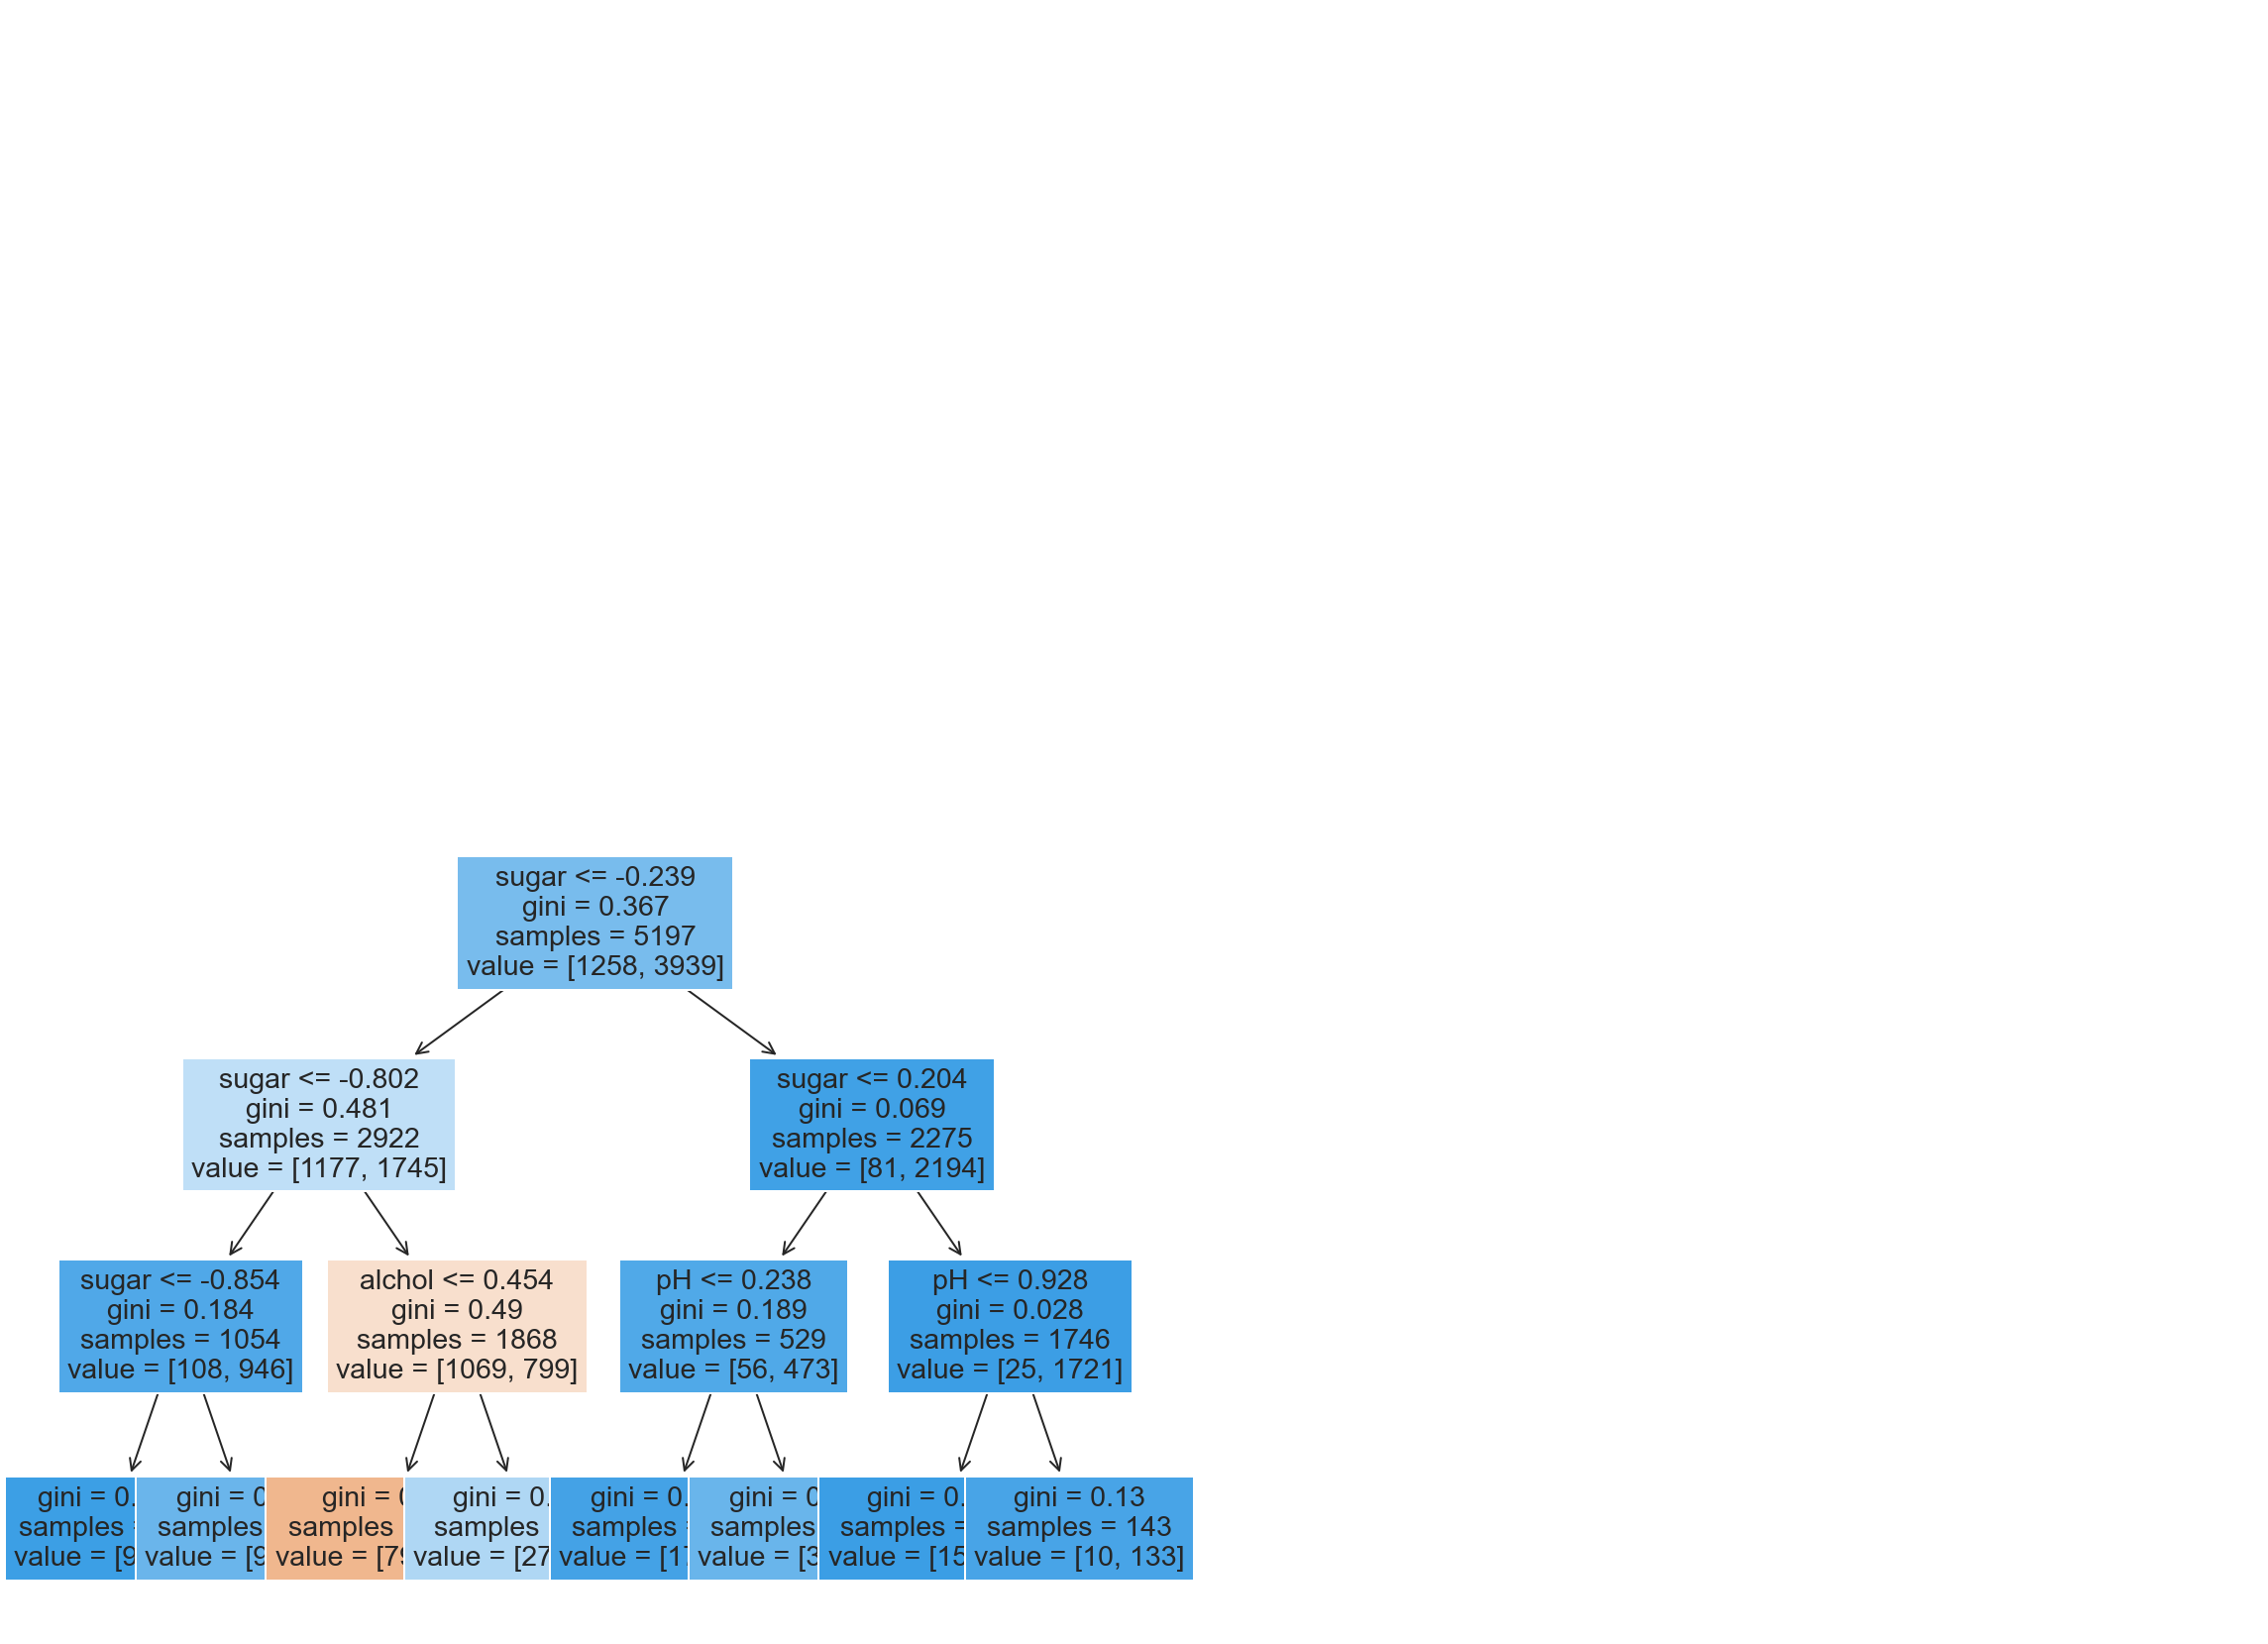

In [28]:
# plot_tree() 함수로 시각화 
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

- 그래프를 따라가면서 샘플이 어떻게 나뉘는지 확인할 수 있다.
- 루트 노드 다음에 있는 깊이 1의 노드는 모두 당도(sugar)를 기준으로 훈련 세트를 나눈다. 
- 하지만 깊이 2의 노드는 맨 왼쪽의 노드만 당도를 기준으로 나누고 왼쪽에서 두 번째 노드는 알코올 도수(alchol)을 기준으로 나누고, 오른쪽 두 노드는 pH를 사용한다.
- 깊이 3에 있는 노드가 최종 노드인 리프 노드이다. 
- 왼쪽에서 세 번째에 있는 노드만 음성 클래스가 더 많다. 이 노드에 도착해야만 레드 와인으로 예측한다는 것을 알 수 있다.
- 루트 노드부터 이 왼쪽 세 번째 노드까지 도달하려면 당도는 -0.239 보다 작고, -0.802 보다 커야한다. 그리고 알코올 도수는 0.454 보다 작아야 한다.(즉 당도가 -0.802 보다 크고 -0.239 보다 작으며, 알코올 도수가 0.454와 같거나 작은 것이 바로 레드 와인이다.)

- 그런데 -0.802라는 음수로 된 당도를 설명해야할까? 앞서 불순도를 기준으로 샘플을 나눈다고 했다. 불순도는 클래스별 비율을 가지고 계산을 한다. 샘플을 어떤 클래스 비율로 나누는지 계산할 때 특성값의 스케일이 계산에 영향을 미칠까?
- 그렇지 않다. **특성값의 스케일은 결정 트리 알고리즘에 아무런 영향을 미치지 않는다. 따라서 표준화 전처리를 할 필요가 없다.** 이것이 결정 트리 알고리즘의 또 따른 장점 중 하나이다.

In [29]:
# 표준화 처리 하지 않고 다시 훈련하기 - 가지치기
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

# 모델 평가 
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


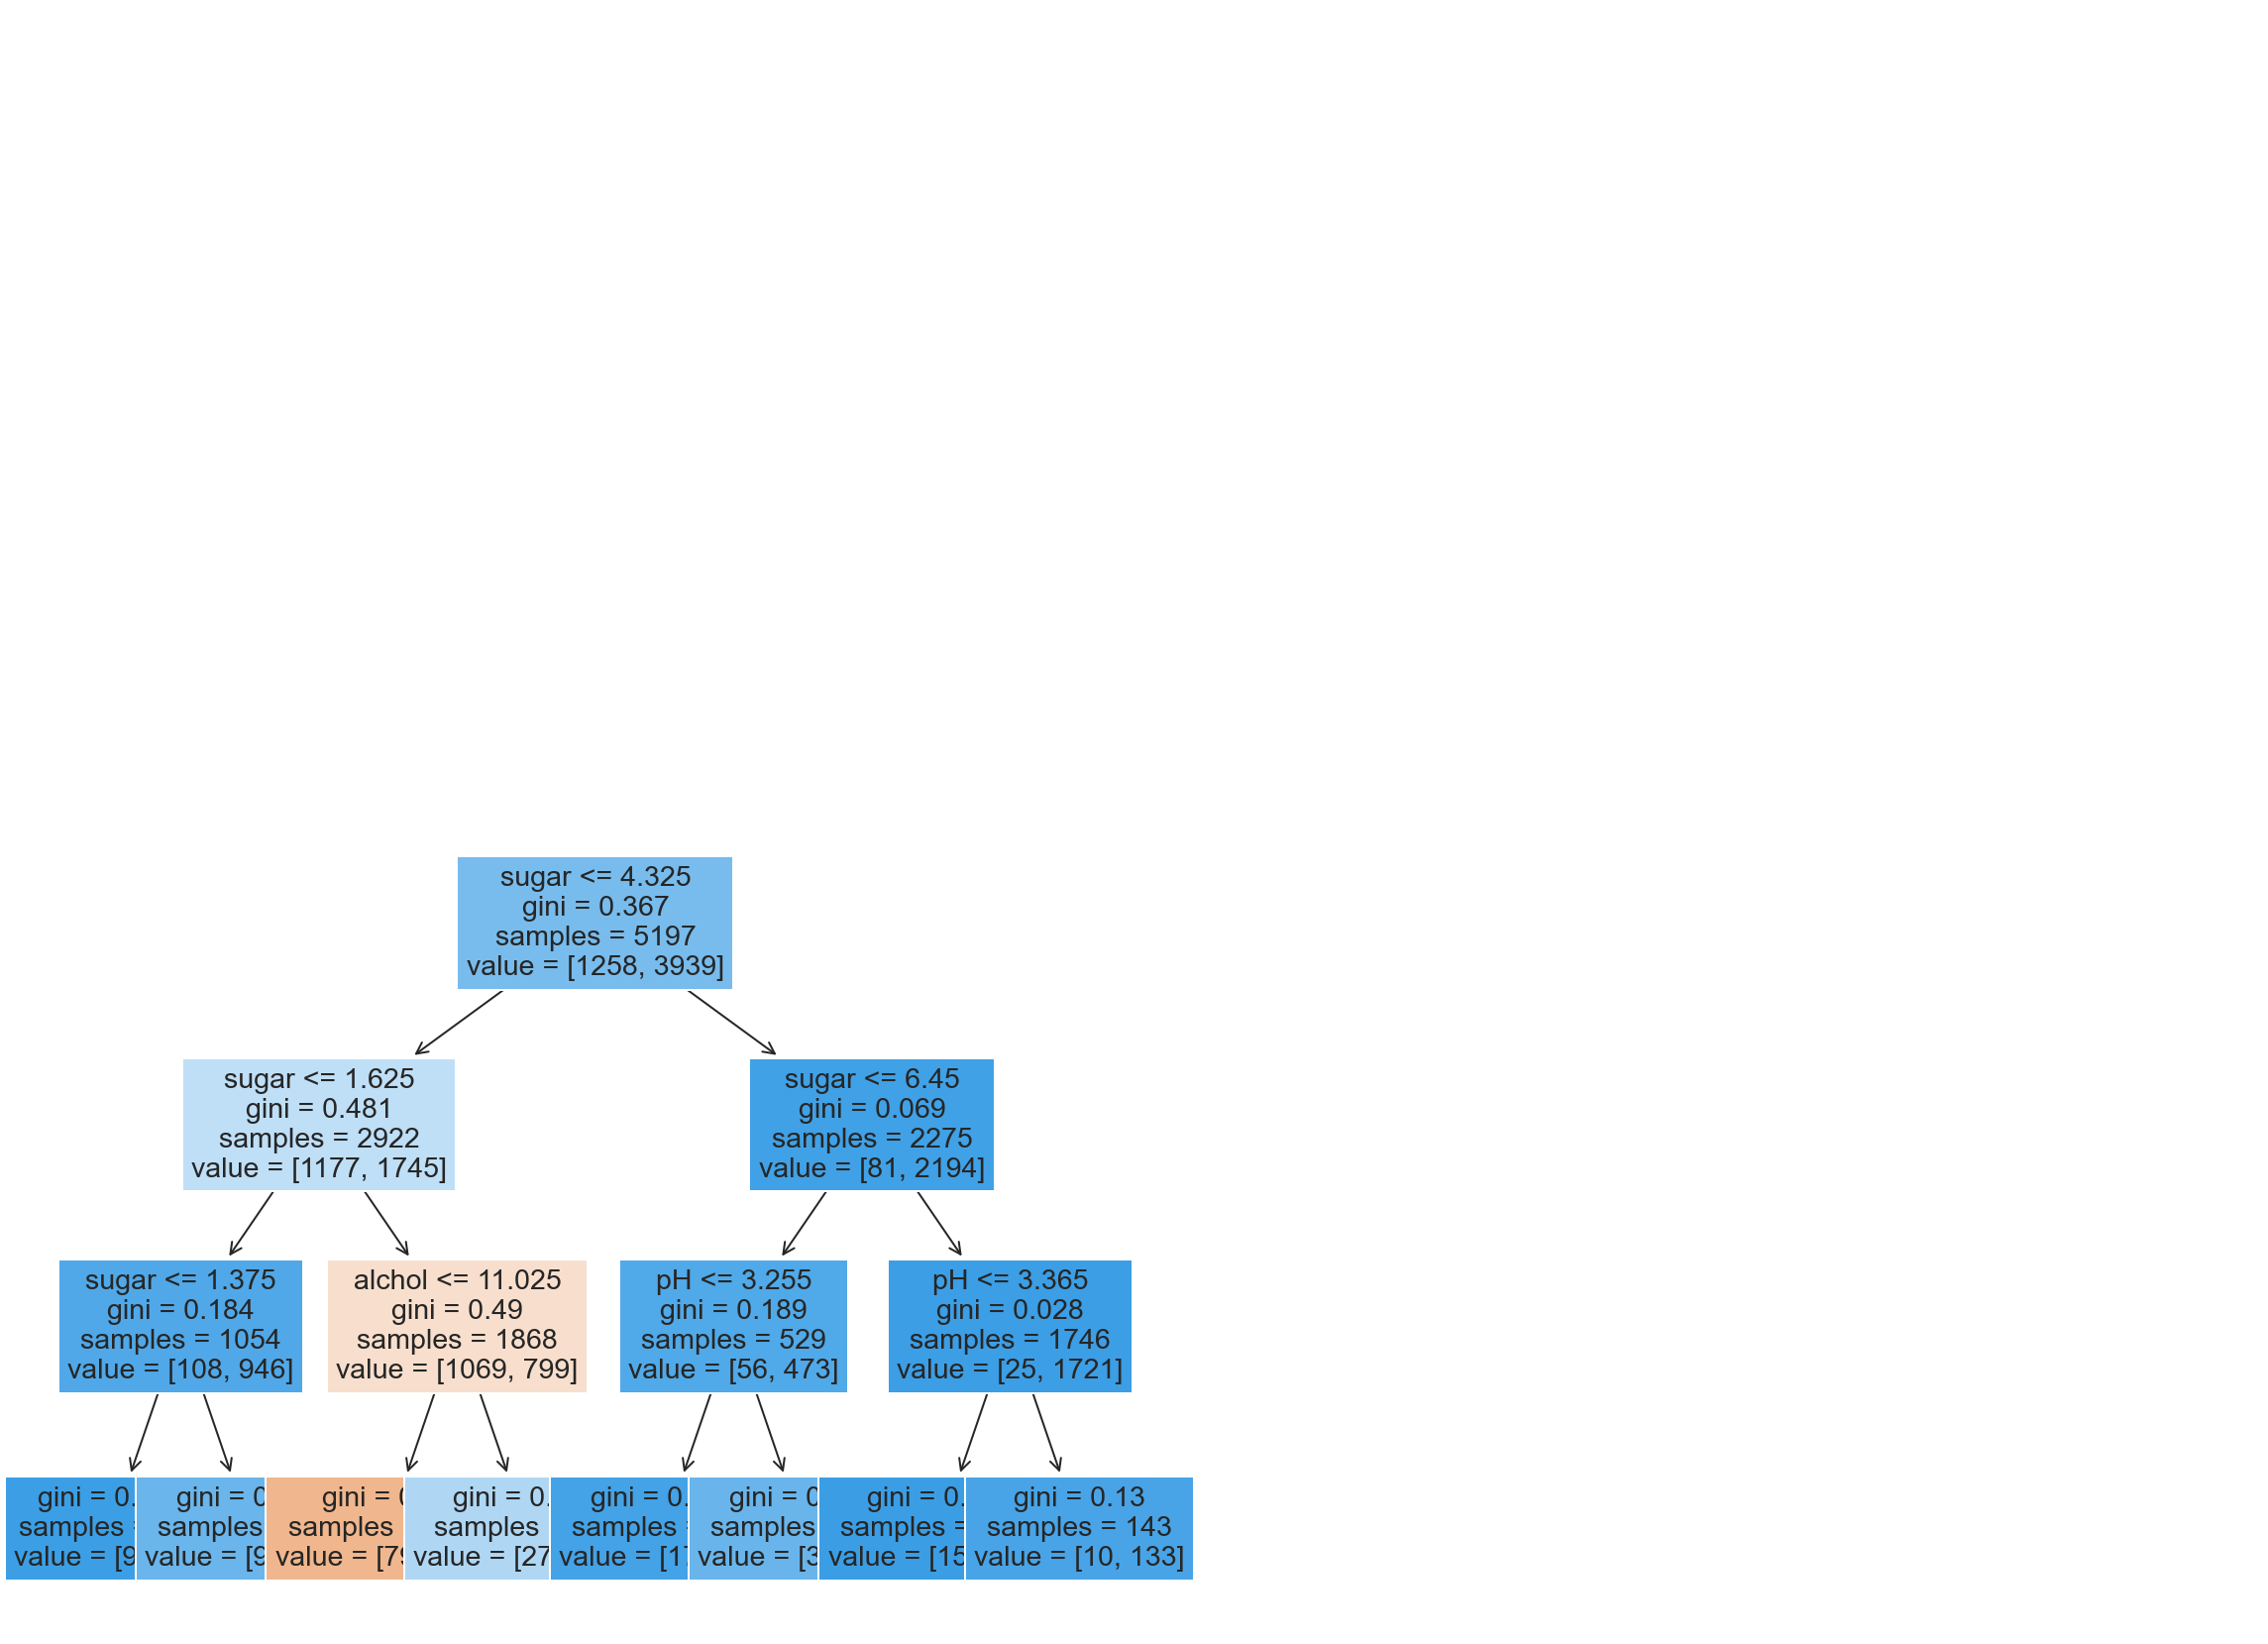

In [30]:
# plot_tree() 함수로 시각화 
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

- 결과를 보면 같은 트리지만, 특성값을 표준점수로 바꾸지 않은 터라 이해하기가 훨씬 쉽다. 
- 당도가 1.625 보다 크고 4.325 보다 작은 와인 중에 알코올 도수가 11.025와 같거나 작은 것이 바로 레드 와인이다. (나머지는 모두 화이트 와인으로 예측)

- 마지막으로 결정 트리는 어떤 특성이 가장 유용한지 나타내는 특성 중요도를 계산해 준다. 
- 이 트리의 루트 노드와 깊이 1에서 당도를 사용했기 때문에 아마도 당도가 가장 유용한 특성 중 하나일 것으로 보인다. 
- 특성 중요도는 결정 트리 모델의 feature_importances_ 속성에 저장되어 있다.

In [31]:
# 특성 중요도 결정 
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


- 특성 중요도 출력 결과 두 번째 특성인 당도가 0.87로 가장 높다. 그다음 알코올 도수, pH 순이다. (이 값을 모두 더하면 1이 된다.)
- 특성 중요도는 각 노드의 정보 이득과 전체 샘플에 대한 비율을 곱한 후 특성별로 더하여 계산한다. 
- 특성 중요도를 활용하면 결정 트리 모델을 특성 선택에 활용할 수 있다. 이것이 결정 트리 알고리즘의 또 다른 장점 중 하나이다.
- 해당 모델은 비록 테스트 세트 성능이 아주 높지 않아 많은 화이트 와인을 완벽하게 골라내지 못했지만, 누군가에게 보고하기는 아주 좋은 모델이다.

## 문제해결 과정 및 결론 
- 해결 과정 
    - 가을 신상품으로 준비한 캔 와인은 실수로 와인의 종류(레드 와인 / 화이트 와인)가 캔에 인쇄되지 않았다.
    - 알코올 도수, 당도, pH 데이터를 기준으로 화이트 와인을 골라내는 이진 분류 로지스틱 회귀 모델을 훈련 했지만, 다른 사람이 보고서를 이해할 수 없었다.
    - 그래서 결정 트리를 사용해 레드 와인과 화이트 와인을 분류하는 문제를 풀었다. 
    - 특성을 더 추가하지 않고도 결정 트리의 성능이 로지스틱 회귀 모델보다 더 좋음을 알 수 있었다. 게다가 결정 트리는 깊이가 너무 깊지 않다면 비교적 설명하기 쉬웠다. 
    - 그리고 결정 트리가 어떻게 데이터를 분할하는지 이해하기 위해 불순도 개념과 정보 이득에 대해 알아보았다.
   
- 결론 
     - 머신러닝 모델을 종종 블랙박스와 같다고도 말한다. 실제로 모델의 계수나 절편이 왜 그렇게 학습되었는지 설명하기가 어렵다.
     - 하지만 결정 트리는 비교적 비전문가에게도 설명하기 쉬운 모델을 만들어 낸다. 
     - 결정 트리는 여기서 끝이 아니다. 결정 트리는 많은 앙상블 학습 알고리즘의 기반이 된다. (앙상블 학습은 신경망과 함께 가장 높은 성능을 내기 때문에 인기가 높은 알고리즘이다.)

In [32]:
# 확인 문제 3번 정답 
dt_1 = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt_1.fit(train_input, train_target)
print(dt_1.score(train_input, train_target))
print(dt_1.score(test_input, test_target))
plt.figure(figsize=(20,15), dpi=300)
plot_tree(dt_1, filled=True, feature_names=['alchol', 'sugar', 'pH'])
plt.show()

0.8874350586877044
0.8615384615384616
